Import all necessary libraries and install everything you need for training:

In [1]:
# install the libraries necessary for data wrangling, prediction and result analysis
import json
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score,precision_score, recall_score
import torch
from numba import cuda
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier

In [2]:
# Install transformers
# (this needs to be done on Kaggle each time you start the session)
#!pip install -q transformers

In [2]:
# Install the simpletransformers
#!pip install -q simpletransformers
from simpletransformers.classification import ClassificationModel

In [4]:
# Install wandb
#!pip install -q wandb

In [3]:
import wandb

In [4]:
# Login to wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tajak (use `wandb login --relogin` to force relogin)


True

In [5]:
# Clean the GPU cache

cuda.select_device(0)
cuda.close()
cuda.select_device(0)
torch.cuda.empty_cache()


### Import the data

In [6]:
# GINCO downcast set
train_df = pd.read_csv("data-splits/GINCO-downcast-train.csv", index_col = 0)
dev_df = pd.read_csv("data-splits/GINCO-downcast-dev.csv", index_col = 0)
test_df = pd.read_csv("data-splits/GINCO-downcast-test.csv", index_col = 0)

print("GINCO train shape: {}, Dev shape: {}, Test shape: {}.".format(train_df.shape, dev_df.shape, test_df.shape))

GINCO train shape: (601, 2), Dev shape: (201, 2), Test shape: (200, 2).


In [7]:
train_df.head()

,text,labels
324,"Ja tudi meni se zdi grdo, da moram razlagati z...",Forum
253,Bo kolesarjenje postalo del zimskih športov? <...,News/Reporting
674,Teptanje ustave namesto prevzema odgovornosti ...,Opinion/Argumentation
600,Cena odtisa za Canon i990 <p/> Zdaj smo končno...,Opinion/Argumentation
460,Veronikin tek je idealna priložnost za priprav...,Promotion


## Testing

We will use the multilingual XLM-RoBERTa model
https://huggingface.co/xlm-roberta-base

In [10]:
# Create a file to save results into (you can find it under Data: Output). Be careful, run this step only once to not overwrite the results file.
#results = []

#with open("results/FTD-Experiments-Results.json", "w") as results_file:
#    json.dump(results,results_file, indent= "")

In [8]:
# Open the main results file:

previous_results_file = open("results/GINCO-Experiments-Results.json")
previous_results = json.load(previous_results_file)
len(previous_results)

14

In [8]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [9]:
# Create a list of labels
LABELS = train_df.labels.unique().tolist()
LABELS

['Forum',
 'News/Reporting',
 'Opinion/Argumentation',
 'Promotion',
 'Information/Explanation',
 'List of Summaries/Excerpts',
 'Other',
 'Instruction',
 'Legal/Regulation']

In [11]:
# Initialize Wandb
run = wandb.init(project="GINCO-hyperparameter-search", entity="tajak", name="testing-trained-model")

In [11]:
# Load the saved model
#artifact = run.use_artifact('tajak/GINCO-hyperparameter-search/#GINCO-downcast-classifier:v0', type='model')
#artifact_dir = artifact.download()

# Loading a local save
model = ClassificationModel(
    "xlmroberta", "artifacts/GINCO-downcast-classifier:v0")

/home/tajak/anaconda3/lib/python3.9/site-packages/simpletransformers/classification/classification_model.py:459: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  warnings.warn(


In [12]:
def testing(test_df, test_name):
    """
    This function takes the test dataset and applies the trained model on it to infer predictions.
    It also prints and saves a confusion matrix, calculates the F1 scores and saves the results in a list of results.

    Args:
    - test_df (pandas DataFrame)
    - test_name
    """
    # Get the true labels
    y_true = test_df.labels
    
    # Calculate the model's predictions on test
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = test_df.text.apply(make_prediction)
    test_df["y_pred_GINCO_downcast"] = y_pred

    # Calculate the scores
    macro = f1_score(y_true, y_pred, labels=LABELS, average="macro")
    micro = f1_score(y_true, y_pred, labels=LABELS,  average="micro")
    print(f"Macro f1: {macro:0.3}, Micro f1: {micro:0.3}")

    # Plot the confusion matrix:
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = LABELS
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    plt.title(f"{test_name}")

    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig(f"figures/Confusion-matrix-{test_name}.png",dpi=100)

    # Save the results:
    rezdict = {
        "experiment": test_name,
        "num_train_epochs": 15,
        "train_batch_size":8,
        "learning_rate": 1e-5,
        "microF1": micro,
        "macroF1": macro,
        "y_true": y_true.to_dict(),
        "y_pred": y_pred.to_dict(),
        }
    previous_results.append(rezdict)

    #Save intermediate results (just in case)
    backup = []
    backup.append(rezdict)
    with open(f"backup-results-{test_name}.json", "w") as backup_file:
        json.dump(backup,backup_file, indent= "")

    # Save the new dataframe which contains the y_pred values as well
    test_df.to_csv(f"results/{test_name}-sheet-with-predictions.csv", sep="\t")

Macro f1: 0.741, Micro f1: 0.701


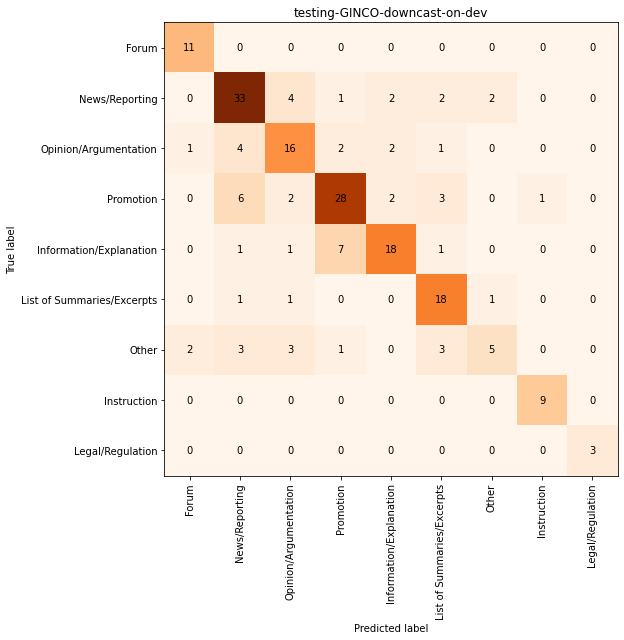


Testing finished.


<Figure size 432x288 with 0 Axes>

In [15]:
testing(dev_df, "testing-GINCO-downcast-on-dev")

print("\nTesting finished.")

Macro f1: 0.73, Micro f1: 0.715


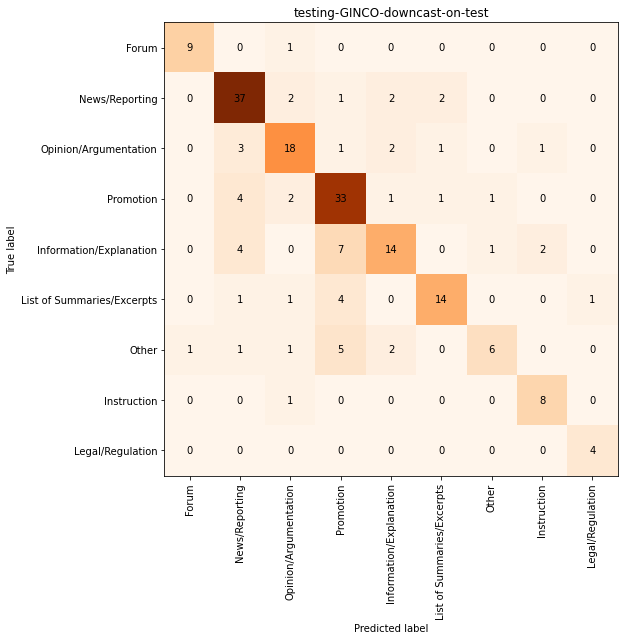


Testing finished.


<Figure size 432x288 with 0 Axes>

In [16]:
testing(test_df, "testing-GINCO-downcast-on-test")
print("\nTesting finished.")

In [17]:
# Compare the results by creating a dataframe from the previous_results dictionary:
results_df = pd.DataFrame(previous_results)

results_df

,experiment,num_train_epochs,train_batch_size,learning_rate,microF1,macroF1,y_true,y_pred
0,Dev-epoch-search:1,1,8,0.00001,0.238342,0.085359,"{'245': 'Call', '143': 'Invitation', '146': 'N...","{'245': 'News/Reporting', '143': 'Information/..."
1,Dev-epoch-search:12,12,8,0.00001,0.585492,0.417602,"{'245': 'Call', '143': 'Invitation', '146': 'N...","{'245': 'News/Reporting', '143': 'Invitation',..."
2,Dev-epoch-search:15,15,8,0.00001,0.658031,0.504828,"{'245': 'Call', '143': 'Invitation', '146': 'N...","{'245': 'News/Reporting', '143': 'Promotion of..."
3,Dev-epoch-search:20,20,8,0.00001,0.637306,0.530084,"{'245': 'Call', '143': 'Invitation', '146': 'N...","{'245': 'News/Reporting', '143': 'Promotion', ..."
4,Dev-epoch-search:25,25,8,0.00001,0.626943,0.497636,"{'245': 'Call', '143': 'Invitation', '146': 'N...","{'245': 'News/Reporting', '143': 'Promotion of..."
5,testing-GINCO-full-set-model-on-dev,20,8,0.00001,0.668394,0.539277,"{'245': 'Call', '143': 'Invitation', '146': 'N...","{'245': 'News/Reporting', '143': 'Invitation',..."
6,FTD-classifier-predictions-on-test,20,8,0.00001,0.590674,0.465714,"{'574': 'Opinionated News', '636': 'Informatio...","{'574': 'News/Reporting', '636': 'Information/..."
7,GINCO-full-set-classifier-predictions-on-test,20,8,0.00001,0.590674,0.465714,"{'574': 'Opinionated News', '636': 'Informatio...","{'574': 'News/Reporting', '636': 'Information/..."
8,GINCO-downcast-dev-epoch-search:8,8,8,0.00001,0.527363,0.267149,"{'648': 'Other', '992': 'Instruction', '51': '...","{'648': 'Opinion/Argumentation', '992': 'Promo..."
9,GINCO-downcast-dev-epoch-search:10,10,8,0.00001,0.721393,0.719435,"{'648': 'Other', '992': 'Instruction', '51': '...","{'648': 'Forum', '992': 'Instruction', '51': '..."


In [18]:
# Save the file with updated results.
with open("results/GINCO-Experiments-Results.json", "w") as results_file:
    json.dump(previous_results,results_file, indent= "")

## Predict GINCO labels to other datasets

In [13]:
# Create a function to predict
def predict_GINCO(df, new_file_name):
    """
    This function takes a dataset and applies the trained model on it to infer predictions.
	It returns and saves the resulting df with added columns with GINCO predictions.

    Args:
    - df: dataframe on which we want to apply prediction. The text should be in a column "text".
    - new_file_name: define the name of the new file
    """
    # Predict on the df
    def make_prediction(input_string):
        return model.predict([input_string])[0][0]

    y_pred = df.text.apply(make_prediction)

    df["GINCO_downcast_pred"] = y_pred

    # Save the new dataframe which contains the y_pred values as well
    df.to_csv(f"{new_file_name}", sep="\t")

    return df

Prediction takes around 22 minutes per 1000 instances.

### Predict GINCO to CORE

In [14]:
# Import data about CORE
core_df = pd.read_csv("data-sheets-with-all-info/CORE-all-information.csv", index_col=0)

core_df

,label,text,split,main_labels,sublabels,Len,main_len,sub_len,GINCORE,full_names,main_labels_full_names,FTD_pred
0,NA OP SR OB,The Top TEN 'Whiniest Sets of Fans' in English...,train,NA OP,SR OB,4,2,2,NA OP SR OB,SR OB,NA OP,NaN
1,NA NE,"Ferry consultation needs deeper questions, say...",train,NaN,NE,2,1,1,News,News Report/Blog,Narrative,NaN
2,ID DF,I'v been recording and mixing music for about ...,train,ID,DF,2,1,1,Forum,Discussion Forum,Interactive Discussion,NaN
3,NA SR,The 25-year-old did have chances at Anfield. B...,train,NaN,SR,2,1,1,News,Sports Report,Narrative,NaN
4,NA IN HA,Elizabethan Science and Technology Elizabethan...,train,NA IN,HA,3,2,1,NA IN HA,Historical Article,NA IN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
48444,NA NE,Lollapalooza heading to the Middle East in 201...,dev,NaN,NE,2,1,1,News,News Report/Blog,Narrative,NaN
48445,OP AV,How to: Improve Brand Engagement on Twitter Ea...,dev,OP,AV,2,1,1,Opinion/Argumentation,Advice,Opinion,NaN
48446,OP OB,The Last Post. A shameful reflection on Canada...,dev,OP,OB,2,1,1,Opinion/Argumentation,Opinion Blog,Opinion,A1 (argumentative)
48447,NA NE,Related Stories Students at a Sherwood Park hi...,dev,NaN,NE,2,1,1,News,News Report/Blog,Narrative,NaN


As prediction takes a lot of time, we will use a smaller sample of the dataset - I will use a stratified split of the test split (data-splits/CORE-sub-test-sample.csv) which is a stratified based on the subcategories) sample of the whole dataset where we:

* removed instances with more than one subcategory and instances with no subcategories (with main category only)
* removed instances of categories with less than 10 instances

The sample has 1500 instances, like the FTD dataset.

In [20]:
# Import
core_sample = pd.read_csv("data-splits/CORE-sub-test-sample.csv", index_col=0)

core_sample

,text,labels
10379,The table below shows UK prices for the iPad M...,News Report/Blog
36572,You can protect your kids for every possibly h...,News Report/Blog
2751,Pages 19 September 2012 Murder in East Timor t...,News Report/Blog
1804,Hadean Era Abstract A brief description of the...,Encyclopedia Article
12696,28 and he was returning and sitting in his cha...,Religious Blogs/Sermons
...,...,...
15611,What was Australia's 1967 Referendum about? Th...,Historical Article
25484,related stories Cox happy ahead of Middle Park...,Sports Report
16340,"Blog Wells-Next-The-Sea -- ""Keep in Front of t...",Reviews
12311,Do you need to complete a tax return? If you h...,FAQ about How-to


In [22]:
# Apply GINCO-downcast classifier to samples
predict_GINCO(core_sample, "CORE-test-sample-GINCO-predicted.csv")

,text,labels,GINCO_downcast_pred
10379,The table below shows UK prices for the iPad M...,News Report/Blog,List of Summaries/Excerpts
36572,You can protect your kids for every possibly h...,News Report/Blog,News/Reporting
2751,Pages 19 September 2012 Murder in East Timor t...,News Report/Blog,News/Reporting
1804,Hadean Era Abstract A brief description of the...,Encyclopedia Article,Information/Explanation
12696,28 and he was returning and sitting in his cha...,Religious Blogs/Sermons,Other
...,...,...,...
15611,What was Australia's 1967 Referendum about? Th...,Historical Article,Information/Explanation
25484,related stories Cox happy ahead of Middle Park...,Sports Report,News/Reporting
16340,"Blog Wells-Next-The-Sea -- ""Keep in Front of t...",Reviews,Opinion/Argumentation
12311,Do you need to complete a tax return? If you h...,FAQ about How-to,Instruction


In [23]:
sample_with_pred = pd.read_csv("CORE-test-sample-GINCO-predicted.csv", sep="\t", index_col = 0)

sample_with_pred

,text,labels,GINCO_downcast_pred
10379,The table below shows UK prices for the iPad M...,News Report/Blog,List of Summaries/Excerpts
36572,You can protect your kids for every possibly h...,News Report/Blog,News/Reporting
2751,Pages 19 September 2012 Murder in East Timor t...,News Report/Blog,News/Reporting
1804,Hadean Era Abstract A brief description of the...,Encyclopedia Article,Information/Explanation
12696,28 and he was returning and sitting in his cha...,Religious Blogs/Sermons,Other
...,...,...,...
15611,What was Australia's 1967 Referendum about? Th...,Historical Article,Information/Explanation
25484,related stories Cox happy ahead of Middle Park...,Sports Report,News/Reporting
16340,"Blog Wells-Next-The-Sea -- ""Keep in Front of t...",Reviews,Opinion/Argumentation
12311,Do you need to complete a tax return? If you h...,FAQ about How-to,Instruction


In [24]:
# Add to the main sheet - core_df
core_df["GINCO_downcast_pred"] = sample_with_pred["GINCO_downcast_pred"]

core_df

,label,text,split,main_labels,sublabels,Len,main_len,sub_len,GINCORE,full_names,main_labels_full_names,FTD_pred,GINCO_downcast_pred
0,NA OP SR OB,The Top TEN 'Whiniest Sets of Fans' in English...,train,NA OP,SR OB,4,2,2,NA OP SR OB,SR OB,NA OP,NaN,NaN
1,NA NE,"Ferry consultation needs deeper questions, say...",train,NaN,NE,2,1,1,News,News Report/Blog,Narrative,NaN,NaN
2,ID DF,I'v been recording and mixing music for about ...,train,ID,DF,2,1,1,Forum,Discussion Forum,Interactive Discussion,NaN,NaN
3,NA SR,The 25-year-old did have chances at Anfield. B...,train,NaN,SR,2,1,1,News,Sports Report,Narrative,NaN,NaN
4,NA IN HA,Elizabethan Science and Technology Elizabethan...,train,NA IN,HA,3,2,1,NA IN HA,Historical Article,NA IN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48444,NA NE,Lollapalooza heading to the Middle East in 201...,dev,NaN,NE,2,1,1,News,News Report/Blog,Narrative,NaN,NaN
48445,OP AV,How to: Improve Brand Engagement on Twitter Ea...,dev,OP,AV,2,1,1,Opinion/Argumentation,Advice,Opinion,NaN,NaN
48446,OP OB,The Last Post. A shameful reflection on Canada...,dev,OP,OB,2,1,1,Opinion/Argumentation,Opinion Blog,Opinion,A1 (argumentative),NaN
48447,NA NE,Related Stories Students at a Sherwood Park hi...,dev,NaN,NE,2,1,1,News,News Report/Blog,Narrative,NaN,NaN


In [25]:
core_df.GINCO_downcast_pred.value_counts()

News/Reporting                481
Opinion/Argumentation         394
Information/Explanation       192
Promotion                     122
List of Summaries/Excerpts     91
Forum                          78
Instruction                    77
Other                          60
Legal/Regulation                5
Name: GINCO_downcast_pred, dtype: int64

In [26]:
# Save the new dataframe
core_df.to_csv("data-sheets-with-all-info/CORE-all-information.csv", sep="\t")

## Predict GINCO to FTD

In [34]:
# Import data
ftd = pd.read_csv("data-sheets-with-all-info/FTD-dataset-with-all-information.csv", sep="\t", index_col = 0)

ftd

,ID,labels,Multiple labels,text,length
0,__id__1-syndicate,A1 (argumentative),NaN,BMW's and Chinese Justice * * * * * In most pl...,975
1,__id__2-syndicate,A1 (argumentative),NaN,China and a New Balance of Power SHANGHAI – Th...,956
2,__id__3-syndicate,A1 (argumentative),NaN,China and Russia in the New World Disorder Can...,978
3,__id__4-syndicate,A1 (argumentative),NaN,The Roots of Chinese / Japanese Rivalry BOSTON...,957
4,__id__5-syndicate,A1 (argumentative),NaN,China's Cyber-Warriors NEW DELHI – The world n...,1034
...,...,...,...,...,...
1681,__id__1682-britannica,A1 (argumentative),NaN,"In Eichmann in Jerusalem , Hannah Arendt descr...",610
1682,__id__1683-britannica,A16 (information),NaN,The vast expanse of the African continent span...,381
1683,__id__1684-britannica,A1 (argumentative),NaN,"Lance Corporal Samantha L. Jones , USMC Politi...",2482
1684,__id__1685-britannica,A12 (promotion),NaN,"Courtesy of the Victoria and Albert Museum , L...",390


In [35]:
predict_GINCO(ftd, "FTD-dataset-with-all-information.csv")

,ID,labels,Multiple labels,text,length,GINCO_downcast_pred
0,__id__1-syndicate,A1 (argumentative),NaN,BMW's and Chinese Justice * * * * * In most pl...,975,News/Reporting
1,__id__2-syndicate,A1 (argumentative),NaN,China and a New Balance of Power SHANGHAI – Th...,956,Information/Explanation
2,__id__3-syndicate,A1 (argumentative),NaN,China and Russia in the New World Disorder Can...,978,Opinion/Argumentation
3,__id__4-syndicate,A1 (argumentative),NaN,The Roots of Chinese / Japanese Rivalry BOSTON...,957,Opinion/Argumentation
4,__id__5-syndicate,A1 (argumentative),NaN,China's Cyber-Warriors NEW DELHI – The world n...,1034,News/Reporting
...,...,...,...,...,...,...
1681,__id__1682-britannica,A1 (argumentative),NaN,"In Eichmann in Jerusalem , Hannah Arendt descr...",610,Information/Explanation
1682,__id__1683-britannica,A16 (information),NaN,The vast expanse of the African continent span...,381,Information/Explanation
1683,__id__1684-britannica,A1 (argumentative),NaN,"Lance Corporal Samantha L. Jones , USMC Politi...",2482,Information/Explanation
1684,__id__1685-britannica,A12 (promotion),NaN,"Courtesy of the Victoria and Albert Museum , L...",390,Information/Explanation
